# Ciclo01: End to End

# 0.0 - IMPORTS 

In [1]:
import random
import pickle

import pandas                 as pd
import numpy                  as np
import seaborn                as sns
import matplotlib.pyplot      as plt


from category_encoders     import TargetEncoder
from IPython.core.display  import HTML
from sklearn               import model_selection    as ms
from sklearn               import preprocessing       as pp
from sklearn               import metrics             as m
from scikitplot            import metrics             as mt
from scipy                 import stats               as ss
from imblearn              import under_sampling      as us
from imblearn              import over_sampling       as oversamp
from imblearn              import combine             as c
from keras                 import models              as ml
from keras                 import layers              as l

2022-04-07 07:32:10.130344: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-04-07 07:32:10.130384: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## 0.1 - Helper functions

In [2]:
def cramer_v(x, y):
    cm = pd.crosstab(x, y).values
    n = cm.sum()
    r, k =  cm.shape
    
    chi2 = ss.chi2_contingency(cm)[0]
    chi2corr = max(0, chi2 - (k-1)*(r-1)/(n-1))
    
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt((chi2corr/n)/(min(kcorr-1, rcorr-1)))

## 0.2 - Loading data

In [3]:
df_raw = pd.read_csv('dataset/train_users_2.csv', low_memory=True)
df_sessions = pd.read_csv('dataset/sessions.csv', low_memory=True)

# 1.0 - DATA DESCRIPTION

In [4]:
df1 = df_raw.copy()

## 1.1 - Data dimensions

In [5]:
print('Number of rows: {}'.format(df1.shape[0]))
print('Number of columns: {}'.format(df1.shape[1]))

Number of rows: 213451
Number of columns: 16


In [6]:
print('Number of rows: {}'.format(df_sessions.shape[0]))
print('Number of columns: {}'.format(df_sessions.shape[1]))

Number of rows: 10567737
Number of columns: 6


## 1.2 - Data type

In [7]:
df1.dtypes

id                          object
date_account_created        object
timestamp_first_active       int64
date_first_booking          object
gender                      object
age                        float64
signup_method               object
signup_flow                  int64
language                    object
affiliate_channel           object
affiliate_provider          object
first_affiliate_tracked     object
signup_app                  object
first_device_type           object
first_browser               object
country_destination         object
dtype: object

## 1.3 - NA check

In [8]:
df1.isna().sum()

id                              0
date_account_created            0
timestamp_first_active          0
date_first_booking         124543
gender                          0
age                         87990
signup_method                   0
signup_flow                     0
language                        0
affiliate_channel               0
affiliate_provider              0
first_affiliate_tracked      6065
signup_app                      0
first_device_type               0
first_browser                   0
country_destination             0
dtype: int64

In [9]:
# ======================== USER =======================#
# date_first_booking
date_first_booking_max = pd.to_datetime(df1['date_first_booking']).max().strftime('%Y-%m-%d')
df1['date_first_booking'] = df1['date_first_booking'].fillna(date_first_booking_max)

# age
df1 = df1[(df1['age']>15) & (df1['age']<120)]
avg_age = df1['age'].mean().astype(int)
df1['age'] = df1['age'].fillna(avg_age)

# first_affiliate_tracked
df1 = df1[~df1['first_affiliate_tracked'].isna()]

# ======================== SESSION =======================#
# user_id
df_sessions = df_sessions[~df_sessions['user_id'].isna()]

# action
df_sessions = df_sessions[~df_sessions['action'].isna()]

# action_type
df_sessions = df_sessions[~df_sessions['action_type'].isna()]

# action_detail
df_sessions = df_sessions[~df_sessions['action_detail'].isna()]

# secs_elapsed
df_sessions = df_sessions[~df_sessions['secs_elapsed'].isna()]

## 1.4 - Change dtypes

In [10]:
# date_account_created
df1['date_account_created'] = pd.to_datetime(df1['date_account_created'])

# timestamp_first_active
df1['timestamp_first_active'] = pd.to_datetime(df1['timestamp_first_active'], format='%Y%m%d%H%M%S')

#date_first_booking
df1['date_first_booking'] = pd.to_datetime(df1['date_first_booking'])

# age
df1['age'] = df1['age'].astype(int)

## 1.5 - Check balanced data

In [11]:
df1['country_destination'].value_counts(normalize=True)

NDF      0.447275
US       0.391867
other    0.061246
FR       0.029918
IT       0.016423
GB       0.014335
ES       0.013740
CA       0.008676
DE       0.006858
NL       0.004852
AU       0.003531
PT       0.001280
Name: country_destination, dtype: float64

## 1.6 Descriptive analysis

In [12]:
# Users
num_attributes = df1.select_dtypes(include=['int64', 'float64'])
cat_attributes = df1.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])
time_attributes = df1.select_dtypes(include=['datetime64[ns]'])

# Sessions
num_attributes_sessions = df_sessions.select_dtypes(include=['int64', 'float64'])
cat_attributes_sessions = df_sessions.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])
time_attributes_sessions = df_sessions.select_dtypes(include=['datetime64[ns]'])

### 1.6.1 - Numerical - Users

In [13]:
# Central Tendecy - Mean and Median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

# Dispersions - Std, min, max, range, skew and kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T
                                       
# Concat
ct = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
ct.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
ct

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,age,16.0,115.0,99.0,37.405591,34.0,13.939844,2.089718,6.516468
1,signup_flow,0.0,25.0,25.0,2.519513,0.0,6.604696,2.705871,5.928298


### 1.6.2 - Numerical - Sessions

In [14]:
# Central Tendecy - Mean and Median
ct1 = pd.DataFrame(num_attributes_sessions.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes_sessions.apply(np.median)).T

# Dispersions - Std, min, max, range, skew and kurtosis
d1 = pd.DataFrame(num_attributes_sessions.apply(np.std)).T
d2 = pd.DataFrame(num_attributes_sessions.apply(min)).T
d3 = pd.DataFrame(num_attributes_sessions.apply(max)).T
d4 = pd.DataFrame(num_attributes_sessions.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes_sessions.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes_sessions.apply(lambda x: x.kurtosis())).T
                                       
# Concat
ct = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
ct.columns = ['attributes_sessions', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
ct

,attributes_sessions,min,max,range,mean,median,std,skew,kurtosis
0,secs_elapsed,0.0,1799977.0,1799977.0,19961.8251,1369.0,88849.388449,11.137761,154.84312


### 1.6.3 - Categorical - Users

In [15]:
cat_attributes.drop('id', axis=1).describe()

,gender,signup_method,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
count,122636,122636,122636,122636,122636,122636,122636,122636,122636,122636
unique,4,3,25,8,17,7,4,9,41,12
top,FEMALE,basic,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF
freq,56362,66039,118205,79093,78954,64712,108283,57943,41778,54852


### 1.6.4 - Categorial - Sessions

In [16]:
cat_attributes_sessions.drop('user_id', axis=1).describe()

,action,action_type,action_detail,device_type
count,9213930,9213930,9213930,9213930
unique,347,10,155,14
top,show,view,view_search_results,Mac Desktop
freq,2178382,3545621,1770931,3019523


###  1.6.5. Correlation Matrix - Sessions

In [17]:
cat_attributes_list = cat_attributes_sessions.drop( 'user_id', axis=1 ).columns.tolist()

corr_dict = {}
for i in range(len(cat_attributes_list)):
    corr_list = []
    for j in range(len(cat_attributes_list)):
        ref = cat_attributes_list[i]
        feat = cat_attributes_list[j]
        
        # correlation
        corr = cramer_v(cat_attributes_sessions[ref], cat_attributes_sessions[feat])
        
        # append a list
        corr_list.append(corr)
    
    # appende a correlation list for each ref attributs
    corr_dict[ref] = corr_list

<AxesSubplot:>

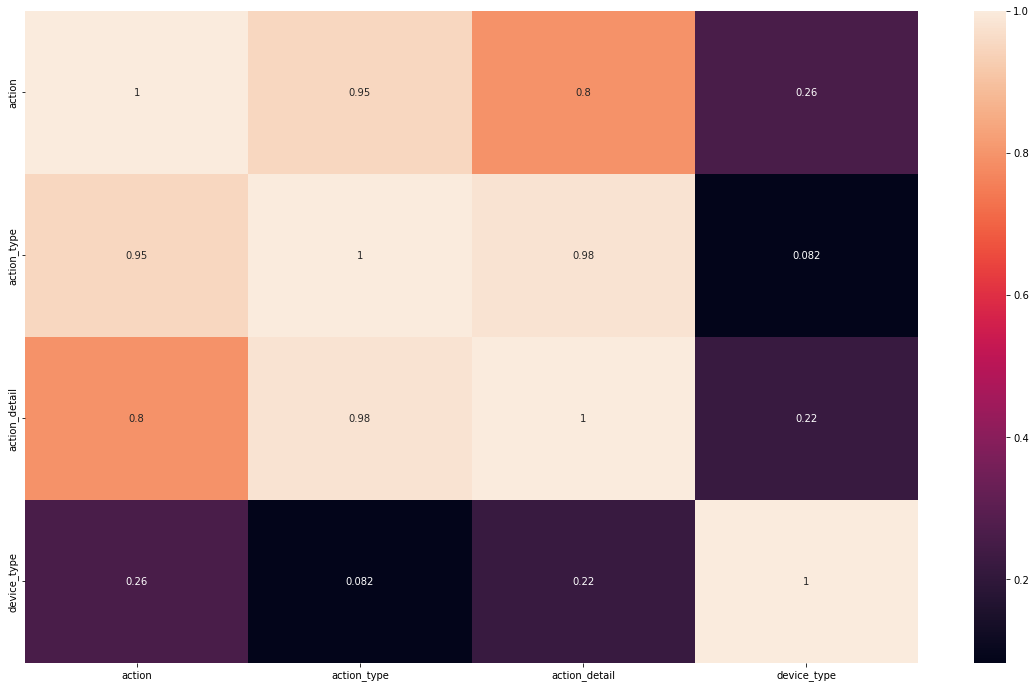

In [18]:
plt.figure(figsize=(20,12))
d = pd.DataFrame(corr_dict)
d = d.set_index(d.columns)
sns.heatmap(d, annot=True)

# 2.0 - FEATURE ENGINEERING

In [19]:
df2 = df1.copy()

## 2.1 - Create new features

In [20]:
# days from first active up to first booking
df2['first_active'] = pd.to_datetime(df2['timestamp_first_active'].dt.strftime('%Y-%m-%d'))
df2['days_from_first_active_until_booking'] = (df2['date_first_booking'] - df2['first_active']).apply(lambda x: x.days)

# days from first active upt to account created
df2['days_from_first_active_until_account_created'] = (df2['date_account_created'] - df2['first_active']).apply(lambda x: x.days)

# days from account created up to first booking
df2['days_from_account_created_until_first_booking'] = (df2['date_first_booking'] - df2['date_account_created']).apply(lambda x: x.days)

# ======================== Active ===========================#
# year first active
df2['year_first_active'] = df2['first_active'].dt.year

# month first active
df2['month_first_active'] = df2['first_active'].dt.month

# day first active
df2['day_first_active'] = df2['first_active'].dt.day

# day of week first active
df2['day_of_week_first_active'] = df2['first_active'].dt.dayofweek

# week of year first active
df2['week_of_year_first_active'] = df2['first_active'].dt.isocalendar().week.astype(int)

# ======================== First Booking ===========================#
# year first booking
df2['year_date_first_booking'] = df2['date_first_booking'].dt.year

# month first booking
df2['month_date_first_booking'] = df2['date_first_booking'].dt.month

# day first booking
df2['day_date_first_booking'] = df2['date_first_booking'].dt.day

# day of week first booking
df2['day_of_year_date_first_booking'] = df2['date_first_booking'].dt.dayofweek

# week of year first booking
df2['week_of_year_date_first_booking'] = df2['date_first_booking'].dt.isocalendar().week.astype(int)

# ======================== Account Created ===========================#
# year account_created
df2['year_date_account_created'] = df2['date_account_created'].dt.year

# month account_created
df2['month_date_account_created'] = df2['date_account_created'].dt.month

# day account_created
df2['day_date_account_created'] = df2['date_account_created'].dt.day

# day of week account_created
df2['day_of_week_date_account_created'] = df2['date_account_created'].dt.dayofweek

# week of year account_created
df2['week_of_year_date_account_created'] = df2['date_account_created'].dt.isocalendar().week.astype(int)

# 3.0 - DATA FILTERING

In [21]:
df3 = df2.copy()

## 3.1 - Filtering rows

In [22]:
# age - greater than 15 and lower than 120 - There are few people over 120 years old
df3 = df3[(df3['age']>15) & df3['age']<120]

# secs_elapsed - there is no possible 0 secs elapsed on website
df_sessions = df_sessions[df_sessions['secs_elapsed']>0]

## 3.2 - Columns selection

In [23]:
cols_drop = ['date_account_created', 'date_first_booking', 'first_active', 'timestamp_first_active'] # original datetime
df3 = df3.drop(cols_drop, axis=1)

# 4.0 BALANCED DATASET

In [24]:
df4 = df3.copy()

In [25]:
# Encoder Categorical Variables
ohe = pp.OneHotEncoder()

# Numerical
col_num = df4.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Categorical
col_cat = df4.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]']).drop(['id', 'country_destination'], axis=1).columns.tolist()

# encoding
df4_dummy = pd.DataFrame(ohe.fit_transform(df4[ col_cat]).toarray(), index=df4.index )

# join numerical and categorical
df41 = pd.concat([df4[col_num], df4_dummy], axis=1)
df41.columns = df41.columns.map(str)
df41.shape

(122636, 138)

## 4.1 Random Undersampling

In [26]:
# raio_balanced
ratio_balanced = {'NDF': 10000}

# define sampler
undersampling = us.RandomUnderSampler(sampling_strategy=ratio_balanced, random_state=32)

# apply sampler
x_under, y_under = undersampling.fit_resample(df41, df4['country_destination'])

In [27]:
df4['country_destination'].value_counts()

NDF      54852
US       48057
other     7511
FR        3669
IT        2014
GB        1758
ES        1685
CA        1064
DE         841
NL         595
AU         433
PT         157
Name: country_destination, dtype: int64

In [28]:
y_under.value_counts()

US       48057
NDF      10000
other     7511
FR        3669
IT        2014
GB        1758
ES        1685
CA        1064
DE         841
NL         595
AU         433
PT         157
Name: country_destination, dtype: int64

## 4.2 Random Oversampling

In [29]:
# define sampler
oversampling = oversamp.RandomOverSampler(sampling_strategy='auto', random_state=32)

# apply sampler
x_over, y_over = oversampling.fit_resample(df41, df4['country_destination'])

In [30]:
df4['country_destination'].value_counts()

NDF      54852
US       48057
other     7511
FR        3669
IT        2014
GB        1758
ES        1685
CA        1064
DE         841
NL         595
AU         433
PT         157
Name: country_destination, dtype: int64

In [31]:
y_over.value_counts()

NDF      54852
US       54852
other    54852
CA       54852
FR       54852
IT       54852
ES       54852
GB       54852
NL       54852
DE       54852
AU       54852
PT       54852
Name: country_destination, dtype: int64

## 4.3 - SMOTE + TOMEKLINK

In [32]:
 ratio_balanced =  {'NDF': 54852,
                   'US':  48057,
                   'other': 6*7511,
                   'FR': 12*3669,
                   'IT': 20*2014,
                   'GB': 30*1758,
                   'ES': 30*1685,
                   'CA': 40*1064,
                   'DE': 45*841,
                   'NL': 80*595,
                   'AU': 85*433,
                   'PT': 300*157}

In [33]:
## define sampler
#smt = c.SMOTETomek(sampling_strategy=ratio_balanced, random_state=32, n_jobs=-1)
#
## apply sampler
#x_smt, y_smt = smt.fit_resample(df41, df4['country_destination'])

In [34]:
## Pickle smt
#with open('smt.pickle', 'wb') as handle:
#    pickle.dump(df45, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Load pickle smt  
with open('smt.pickle', 'rb') as handle:
    df_smt = pickle.load(handle)

In [35]:
df4['country_destination'].value_counts()

NDF      54852
US       48057
other     7511
FR        3669
IT        2014
GB        1758
ES        1685
CA        1064
DE         841
NL         595
AU         433
PT         157
Name: country_destination, dtype: int64

In [36]:
df_smt['country_destination'].value_counts()

NDF      54850
GB       52688
ES       50508
NL       47598
US       47543
PT       47100
other    44760
FR       43868
CA       42541
IT       40199
DE       37829
AU       36803
Name: country_destination, dtype: int64

In [37]:
## numerical data
#df42 = x_smt[col_num]
#
#
## categorical data
#df43 = x_smt.drop(col_num, axis=1)
#df44 = pd.DataFrame(ohe.inverse_transform(df43), columns=col_cat, index=df43.index)
#
## join numerical categorical
#df45 = pd.concat([df42, df44], axis=1)
#df45['country_destination'] = y_smt

# 5.0 - EXPLORATORY DATA ANALYSIS (EDA)

In [38]:
df51 = df4.copy()
df52 = df_smt.copy()

## 5.1 - Bivariate analysis - Hypothesis validation (Unbalanced dataset)

### **H01.** Em todos os destinos os usuários levam 15 dias, em média,para fazer a primeira reserva no Airbnb desde sua primeira ativação.

**VERDADEIRO** Em todos os destinos os usuários levam 6 dias para reservar o primeiro Airbnb.

<AxesSubplot:xlabel='country_destination', ylabel='days_from_first_active_until_booking'>

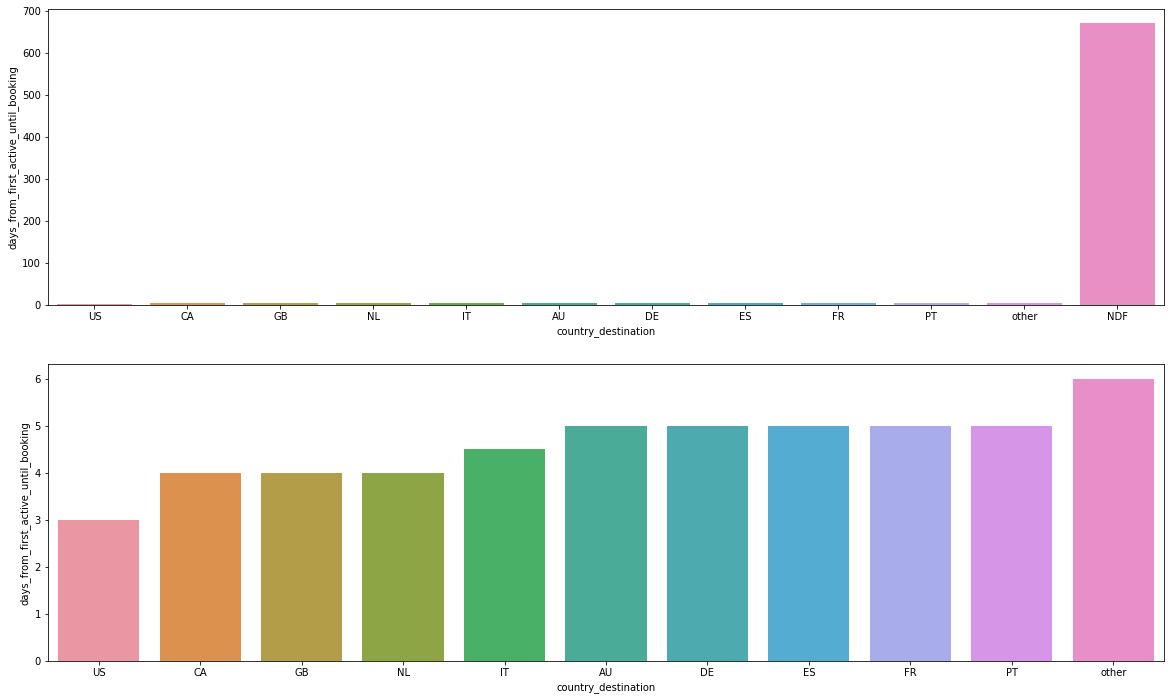

In [39]:
plt.figure(figsize=(20,12))
plt.subplot(2,1,1)
aux1 = df51[['days_from_first_active_until_booking', 'country_destination']].groupby('country_destination').median().reset_index()
sns.barplot(x='country_destination', y='days_from_first_active_until_booking', data=aux1.sort_values('days_from_first_active_until_booking'))

# remove outlier
plt.subplot(2,1,2)
aux2 = df51[df51['country_destination']!='NDF']
aux2 = aux2[['days_from_first_active_until_booking', 'country_destination']].groupby('country_destination').median().reset_index()
sns.barplot(x='country_destination', y='days_from_first_active_until_booking', data=aux2.sort_values('days_from_first_active_until_booking'))

### **H02.** Em todos os destinos os usuários levam 3 dias, em média, para fazer o cadastro no site.

**VERDADEIRO** Os usuários levam até 2 dias para faer o cadastro no site

<AxesSubplot:xlabel='country_destination', ylabel='days_from_first_active_until_account_created'>

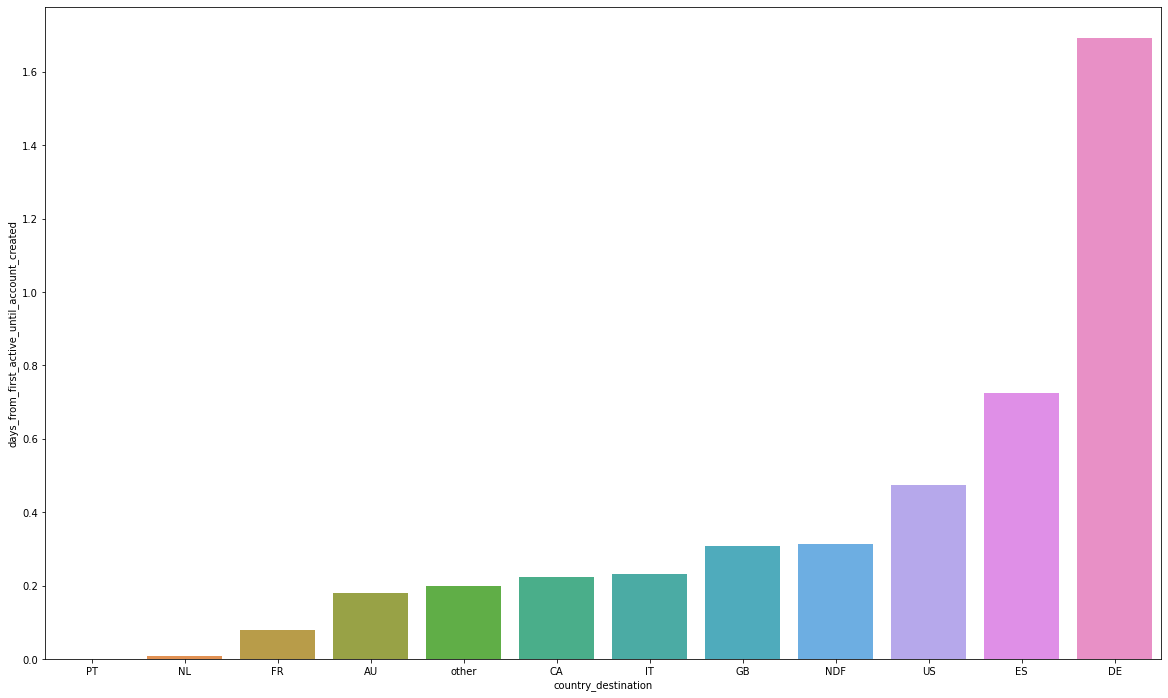

In [40]:
plt.figure(figsize=(20,12))
aux1 = df51[['days_from_first_active_until_account_created', 'country_destination']].groupby('country_destination').mean().reset_index()
sns.barplot(x='country_destination', y='days_from_first_active_until_account_created', data=aux1.sort_values('days_from_first_active_until_account_created'))

### **H03.** O volume de reservas anual feitas durante o verão aumentaram 20% para destinos dentro dos USA.

**FALSA** O volume de reservas aumenta durante o verão entre 2010 e 2013.

<AxesSubplot:xlabel='year_date_first_booking', ylabel='delta'>

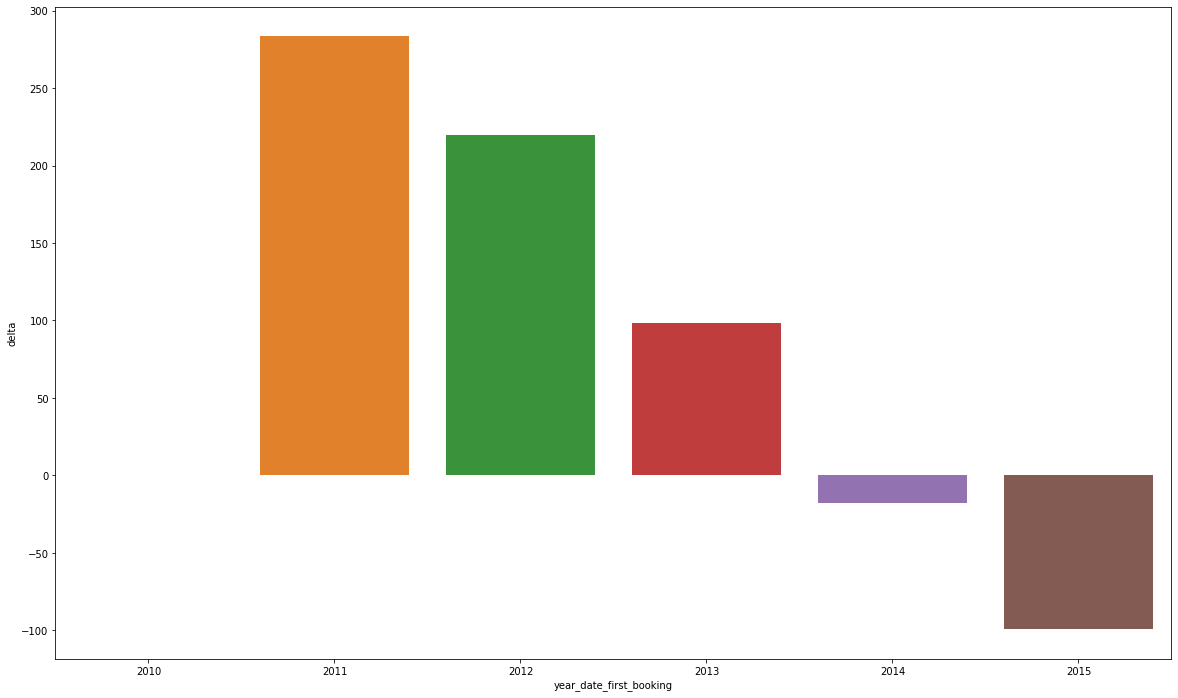

In [41]:
aux1 = df51[['year_date_first_booking', 'month_date_first_booking', 'country_destination']].\
    groupby(['year_date_first_booking', 'month_date_first_booking', 'country_destination']).\
    size().reset_index().rename(columns={0: 'count'})

# select only summer
aux1 = aux1[(aux1['month_date_first_booking'].isin([6,7,8,9])) & (aux1['country_destination']=="US")]

aux2 = aux1[['year_date_first_booking', 'count']].groupby('year_date_first_booking').sum().reset_index()
aux2['delta'] = 100*aux2['count'].pct_change().fillna(0)

plt.figure(figsize=(20,12))
sns.barplot(x='year_date_first_booking', y='delta', data=aux2)

**H04.** Usuários do sexo feminino fazer 10% mas reservas para países fora dosUSA.

**H05.** O canal de marketing Google representa 40% das reservas para países fora dos USA.

**H06.** O destino dos EUA representa mais de 20% em todos os canais.

**H07.** A idade médias das pessoas é de 35 anos em todos os destinos.

**H08.** A porcentagem de usuários que usam o site na língua inglês americano para reservar acomodações em qualquer destino é maior que 90%.

**H09.** O número de reservas do Airbnb é crescente ao longo dos anos.

**H10.** O número de reservas do Airbnb é crescente ao longo dos anos.

## 5.2 - Variables impact (balanced dataset)

In [42]:
num_attributes = df52.select_dtypes(include=['int64', 'float64'])
cat_attributes = df52.select_dtypes(exclude=['int64', 'float64', 'datetime'])

### 5.2.1 - Univariated analysis

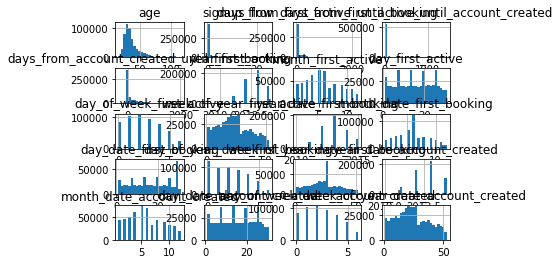

In [43]:
num_attributes.hist(bins=25);

### 5.2.2 - Bivariated analysis

### 5.2.3 - Multivariated analysis

#### 5.2.3.1 - Numerical

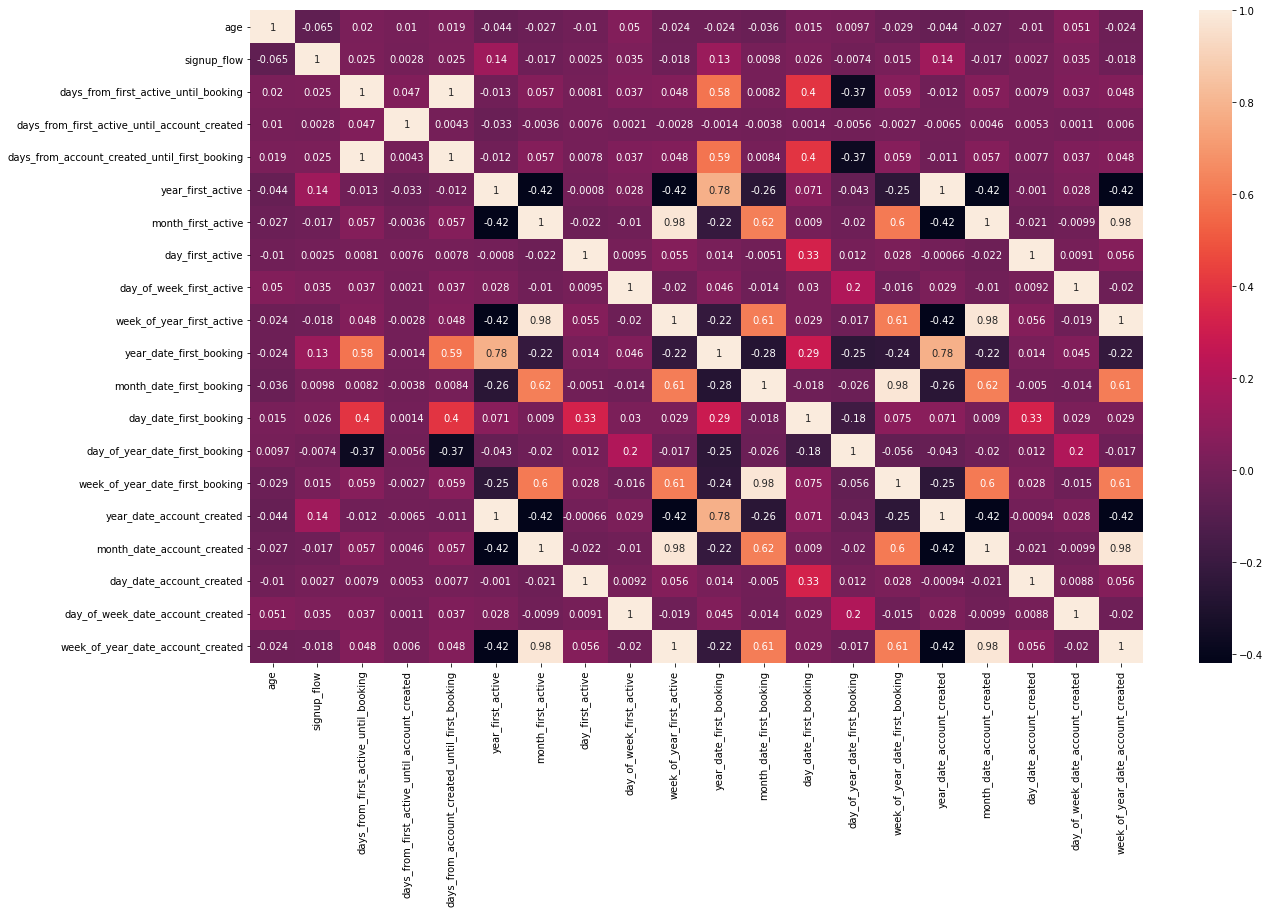

In [44]:
correlation = num_attributes.corr(method='pearson')

plt.figure(figsize=(20,12))
sns.heatmap(correlation, annot=True);

#### 5.2.3.2 - Categorical

In [45]:
cat_attributes_list = cat_attributes.columns.tolist()

corr_dict = {}
for i in range(len(cat_attributes_list)):
    corr_list = []
    for j in range(len(cat_attributes_list)):
        ref = cat_attributes_list[i]
        feat = cat_attributes_list[j]
        
        # correlation
        corr = cramer_v(cat_attributes[ref], cat_attributes[feat])
        
        # append a list
        corr_list.append(corr)
    
    # appende a correlation list for each ref attributs
    corr_dict[ref] = corr_list

<AxesSubplot:>

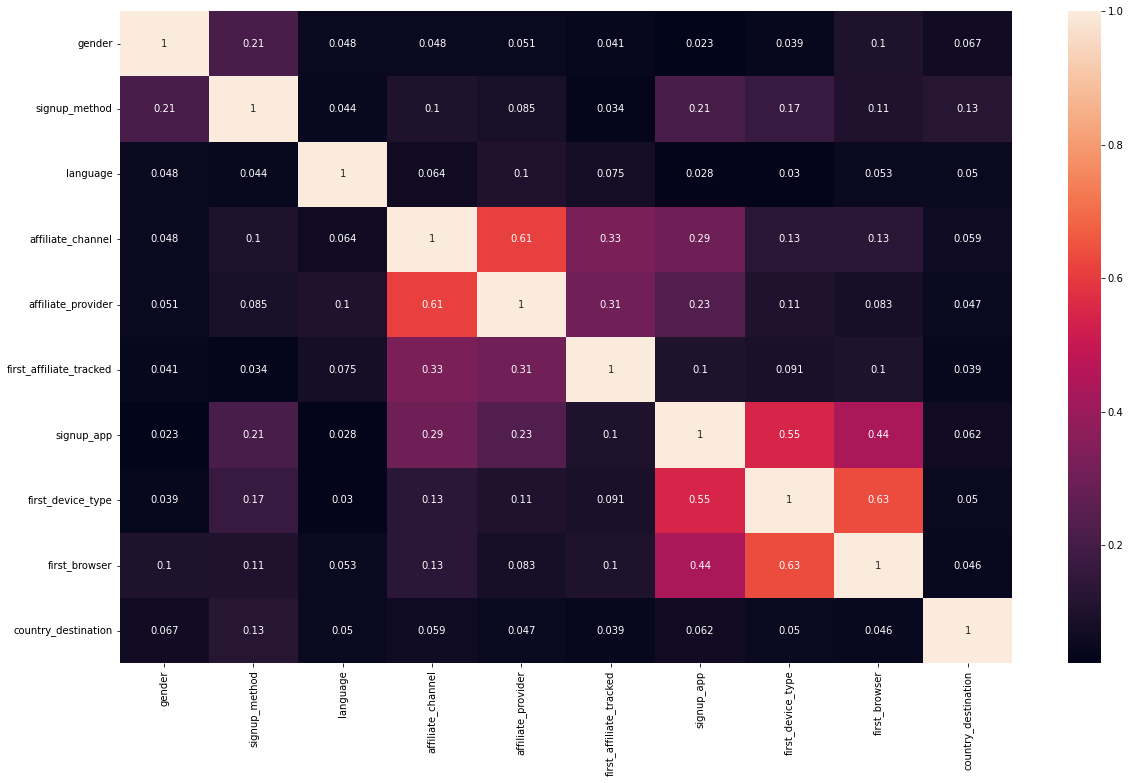

In [46]:
plt.figure(figsize=(20,12))
d = pd.DataFrame(corr_dict)
d = d.set_index(d.columns)
sns.heatmap(d, annot=True)

#### 5.2.3.3 - Identifying the high correlations and removing columns

In [47]:
#=========== High correlation ===========#
# days_from_first_active_until_booking  x  days_from_first_account_created_until_first_booking
# remove: days_from_first_active_until_booking

# year_first_actve  x  year_account_created
# remove: year_first_active

# month_first_actve  x  month_account_created
# remove: month_first_active

# day_first_actve  x  day_account_created
# remove: day_first_active

# week_of_year_first_actve  x  week_of_year_account_created
# remove: week_of_year_first_active

# day_of_year_first_actve  x  day_of_year_account_created
# remove: day_of_year_first_active

# month_first_booking  x  week_of_year_account_created
# remove: month_first_booking

# month_account_created  x  week_of_year_account_created
# remove: month_account_created

# year_first_booking  x  year_account_created
# remove: year_first_booking

# week_of_year_first_booking  x  wek_of_year_account_created
# remove: week_of_year_first_booking

# affiliate_channel  x  affiliate_provider
# remove: affiliate_provider

# first_device_type  x  first_browser
# remove: first_browser

# first_device_type  x  signup_app
# remove: first_device_type

In [48]:
cols = ['days_from_first_active_until_booking', 'year_first_active', 'month_first_active', 'day_first_active',
        'day_of_week_first_active', 'week_of_year_first_active', 'month_date_first_booking', 'month_date_account_created',
        'year_date_first_booking', 'week_of_year_date_first_booking', 'affiliate_provider',
        'first_browser', 'first_device_type', 'language']

df52 = df52.drop(cols, axis=1)

df52.rename(columns={'day_of_year_date_first_booking': 'day_of_week_date_first_booking'}, inplace=True);

# 6.0 - DATA PREPARATION

In [49]:
df6 = df52.copy()

## 6.1 - Rescaling

In [50]:
ss = pp.StandardScaler()
rs = pp.RobustScaler()
mms = pp.MinMaxScaler()

In [51]:
# age - Standardization
df6['age'] = ss.fit_transform(df6[['age']].values)

# signup_flow - Robust Scaler
df6['signup_flow'] = rs.fit_transform(df6[['signup_flow']].values)

# days_from_first_active_until_account_created - Robust Scaler
df6['days_from_first_active_until_account_created'] = ss.fit_transform(df6[['days_from_first_active_until_account_created']].values)

# days_from_account_created_until_first_booking - Robust Scaler
df6['days_from_account_created_until_first_booking'] = ss.fit_transform(df6[['days_from_account_created_until_first_booking']].values)

# year_account_created - MinMax Scaler
df6['year_date_account_created'] = ss.fit_transform(df6[['year_date_account_created']].values)

## 6.2 - Encoding

In [52]:
te = TargetEncoder()

In [53]:
# gender - One hot encoder
df6 = pd.get_dummies(df6, prefix=['gender'], columns=['gender'])

# signup_method - One hot encoder
df6 = pd.get_dummies(df6, prefix=['signup_method'], columns=['signup_method'])

# affiliate_channel - Target enconding
c = {'NDF':0, 'US':1, 'other':2, 'CA':3, 'FR':4, 'IT':5, 'ES':6, 'GB':7, 'NL':8, 'DE':9, 'AU':10, 'PT':11}
df6['affiliate_channel'] = te.fit_transform(df6[['affiliate_channel']].values, df6['country_destination'].map(c))

# signup_app - One hote encoding
df6 = pd.get_dummies(df6, prefix=['signup_app'], columns=['signup_app'])

# first_affiliate_tracked - Target encoder
df6['first_affiliate_tracked'] = te.fit_transform(df6[['first_affiliate_tracked']].values, df6['country_destination'].map(c))

## 6.3 - Transformation

In [54]:
# week_of_year_date_account_created
df6['week_of_year_date_account_created_sin'] = df6['week_of_year_date_account_created'].apply(lambda x: np.sin(x*2*np.pi/52))
df6['week_of_year_date_account_created_cos'] = df6['week_of_year_date_account_created'].apply(lambda x: np.cos(x*2*np.pi/52))

# day_of_week_date_first_booking
df6['day_of_week_date_first_booking_sin'] = df6['day_of_week_date_first_booking'].apply(lambda x: np.sin(x*2*np.pi/7))
df6['day_of_week_date_first_booking_cos'] = df6['day_of_week_date_first_booking'].apply(lambda x: np.cos(x*2*np.pi/7))

# day_date_account_created
df6['day_date_account_created_sin'] = df6['day_date_account_created'].apply(lambda x: np.sin(x*2*np.pi/31))
df6['day_date_account_created_cos'] = df6['day_date_account_created'].apply(lambda x: np.cos(x*2*np.pi/31))

# day_of_week_date_account_created
df6['day_of_week_date_account_created_sin'] = df6['day_of_week_date_account_created'].apply(lambda x: np.sin(x*2*np.pi/7))
df6['day_of_week_date_account_created_cos'] = df6['day_of_week_date_account_created'].apply(lambda x: np.cos(x*2*np.pi/7))

In [55]:
## dummy variable
#df5_dummy = pd.get_dummies(df5.drop(['id', 'country_destination'], axis=1))
#
## join id and country destination
#df5 = pd.concat([df5[['id', 'country_destination']], df5_dummy], axis=1)

In [56]:
## dummy variable
#df5_dummy = pd.get_dummies(df5.drop(['country_destination'], axis=1))
#
## join id and country destination
##df5 = pd.concat([df5[['id', 'country_destination']], df5_dummy], axis=1)
#df5 = pd.concat([df5[['country_destination']], df5_dummy], axis=1)

# 7.0 - FEATURE SELECTION

In [57]:
df7 = df6.copy()

In [58]:
X = df7.drop(['country_destination'], axis=1)
y = df7['country_destination'].copy()

In [59]:
# Split dataset into training and test
x_train, x_test, y_train, y_test = ms.train_test_split(X, y, test_size=0.2, random_state=32)

# 8.0 MACHINE LEARNING MODEL - NEURAL NETWORK MLP

## 8.1 - Baseline model 

In [60]:
country_destination_list = df1['country_destination'].drop_duplicates().sort_values().tolist()
k_num = y_test.shape[0]
country_destination_weights = df1['country_destination'].value_counts(normalize=True).sort_index().to_list()

# modelo que chuta
yhat_random = random.choices(population=country_destination_list, k=k_num, weights=country_destination_weights)

### 8.1.1 - Baseline model performance

Accuracy: 0.09116952534368193
Balanced Accuracy: 0.08237220527171761
Kappa Score: -0.0010642860680989408
              precision    recall  f1-score   support

          AU       0.07      0.00      0.01      7379
          CA       0.09      0.01      0.02      8444
          DE       0.06      0.01      0.01      7573
          ES       0.09      0.01      0.02     10097
          FR       0.08      0.03      0.04      8841
          GB       0.09      0.01      0.02     10411
          IT       0.07      0.01      0.02      8080
         NDF       0.10      0.45      0.16     10848
          NL       0.08      0.00      0.01      9591
          PT       0.07      0.00      0.00      9444
          US       0.09      0.39      0.14      9626
       other       0.08      0.06      0.07      8924

    accuracy                           0.09    109258
   macro avg       0.08      0.08      0.04    109258
weighted avg       0.08      0.09      0.05    109258



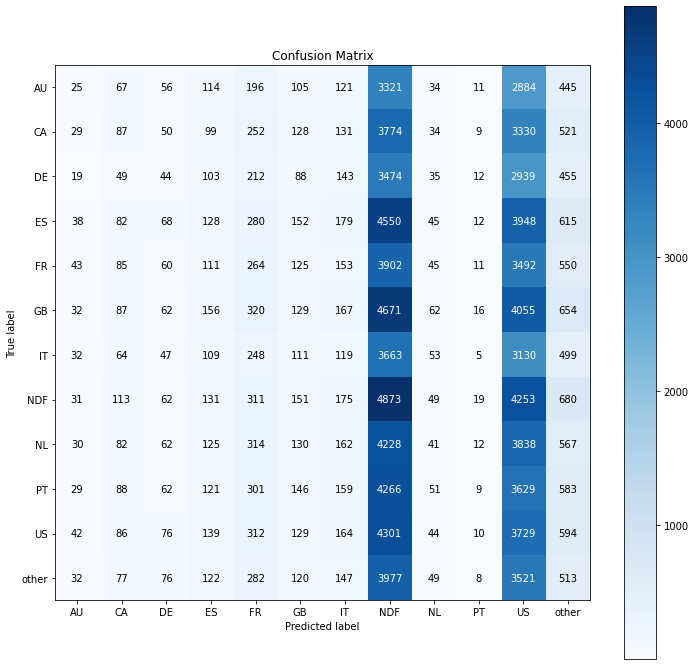

In [61]:
# Accuracy
acc_random = m.accuracy_score(y_test, yhat_random)
print('Accuracy: {}'.format(acc_random))

# Balanced Accuracy
balanced_acc_random = m.balanced_accuracy_score(y_test, yhat_random)
print('Balanced Accuracy: {}'.format(balanced_acc_random))

# Kappa Metrics
kappa_random = m.cohen_kappa_score(y_test, yhat_random)
print('Kappa Score: {}'.format(kappa_random))

# Classification report
print(m.classification_report(y_test, yhat_random))

# Confusion Matrix
mt.plot_confusion_matrix(y_test, yhat_random, normalize=False, figsize=(12, 12));

## 8.2 - Neural network - MLP

In [62]:
ohe = pp.OneHotEncoder()
y_train_nn = ohe.fit_transform(y_train.values.reshape(-1,1)).toarray()

In [63]:
print('Number of rows: {}'.format(x_train.shape[0]))
print('Number of features: {}'.format(x_train.shape[1]))
print('Number of classes: {}'.format(y_train.nunique()))

Number of rows: 437029
Number of features: 31
Number of classes: 12


In [64]:
# model definition
model = ml.Sequential()
model.add(l.Dense(64, input_dim=x_train.shape[1], activation='relu'))
model.add(l.Dense(12, activation='softmax'))

# model_compile
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# trin model
model.fit(x_train, y_train_nn, epochs=100)

2022-04-07 07:33:58.690853: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-04-07 07:33:58.690891: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-04-07 07:33:58.690918: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (fausto-Inspiron-7520): /proc/driver/nvidia/version does not exist


Epoch 1/100


2022-04-07 07:33:58.962258: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 108383192 exceeds 10% of free system memory.


13658/13658 [==============================] - 23s 2ms/step - loss: 2.0949 - accuracy: 0.2482
Epoch 2/100
13658/13658 [==============================] - 22s 2ms/step - loss: 2.0021 - accuracy: 0.2867
Epoch 3/100
13658/13658 [==============================] - 22s 2ms/step - loss: 1.9653 - accuracy: 0.3021
Epoch 4/100
13658/13658 [==============================] - 22s 2ms/step - loss: 1.9424 - accuracy: 0.3111
Epoch 5/100
13658/13658 [==============================] - 22s 2ms/step - loss: 1.9278 - accuracy: 0.3174
Epoch 6/100
13658/13658 [==============================] - 20s 1ms/step - loss: 1.9177 - accuracy: 0.3216
Epoch 7/100
13658/13658 [==============================] - 22s 2ms/step - loss: 1.9099 - accuracy: 0.3244
Epoch 8/100
13658/13658 [==============================] - 22s 2ms/step - loss: 1.9046 - accuracy: 0.3270
Epoch 9/100
13658/13658 [==============================] - 22s 2ms/step - loss: 1.8991 - accuracy: 0.3281
Epoch 10/100
13658/13658 [==============================] 

13658/13658 [==============================] - 21s 2ms/step - loss: 1.8446 - accuracy: 0.3461
Epoch 78/100
13658/13658 [==============================] - 21s 2ms/step - loss: 1.8445 - accuracy: 0.3458
Epoch 79/100
13658/13658 [==============================] - 21s 2ms/step - loss: 1.8441 - accuracy: 0.3463
Epoch 80/100
13658/13658 [==============================] - 21s 2ms/step - loss: 1.8441 - accuracy: 0.3469
Epoch 81/100
13658/13658 [==============================] - 21s 2ms/step - loss: 1.8437 - accuracy: 0.3463
Epoch 82/100
13658/13658 [==============================] - 21s 2ms/step - loss: 1.8436 - accuracy: 0.3465
Epoch 83/100
13658/13658 [==============================] - 21s 2ms/step - loss: 1.8431 - accuracy: 0.3470
Epoch 84/100
13658/13658 [==============================] - 21s 2ms/step - loss: 1.8437 - accuracy: 0.3462
Epoch 85/100
13658/13658 [==============================] - 21s 2ms/step - loss: 1.8431 - accuracy: 0.3459
Epoch 86/100
13658/13658 [========================

### 8.2.1 - NN Performance

In [65]:
# prediction
pred_nn = model.predict(x_test)

# invert_prediction
yhat_nn = ohe.inverse_transform(pred_nn)

# prediction prepare
y_test_nn = y_test.to_numpy()
yhat_nn = yhat_nn.reshape(1, -1)[0]

Accuracy: 0.3447619396291347
Balanced Accuracy: 0.3297810467974413
Kappa Score: 0.283625102610937
              precision    recall  f1-score   support

          AU       0.30      0.40      0.35      7379
          CA       0.17      0.25      0.20      8444
          DE       0.23      0.19      0.20      7573
          ES       0.19      0.27      0.22     10097
          FR       0.15      0.08      0.11      8841
          GB       0.17      0.15      0.16     10411
          IT       0.19      0.02      0.04      8080
         NDF       1.00      1.00      1.00     10848
          NL       0.27      0.39      0.32      9591
          PT       0.58      0.90      0.71      9444
          US       0.27      0.25      0.26      9626
       other       0.16      0.06      0.09      8924

    accuracy                           0.34    109258
   macro avg       0.31      0.33      0.30    109258
weighted avg       0.32      0.34      0.32    109258



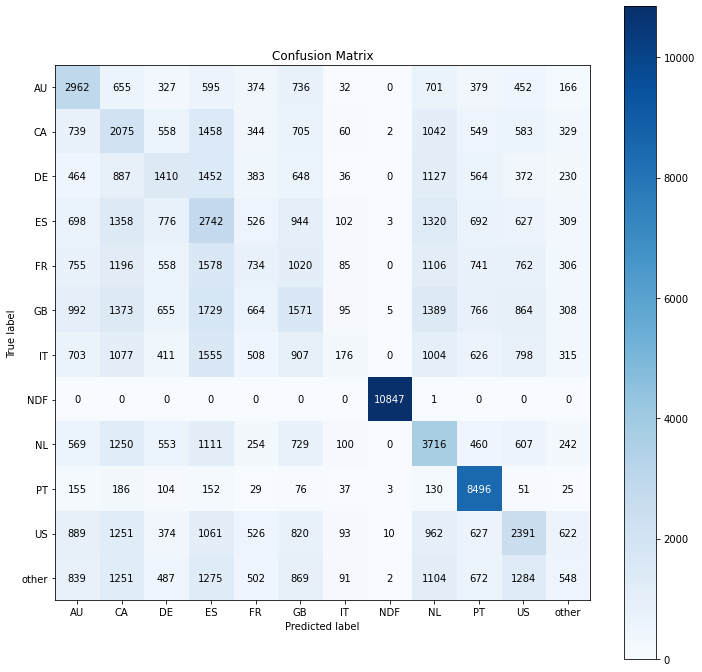

In [66]:
# Accuracy
acc_nn = m.accuracy_score(y_test, yhat_nn)
print('Accuracy: {}'.format(acc_nn))

# Balanced Accuracy
balanced_acc_nn = m.balanced_accuracy_score(y_test_nn, yhat_nn)
print('Balanced Accuracy: {}'.format(balanced_acc_nn))

# Kappa Metrics
kappa_nn = m.cohen_kappa_score(y_test_nn, yhat_nn)
print('Kappa Score: {}'.format(kappa_nn))

# Classification report
print(m.classification_report(y_test_nn, yhat_nn))

# Confusion Matrix
mt.plot_confusion_matrix(y_test_nn, yhat_nn, normalize=False, figsize=(12, 12));

### 8.2.2- NN Performance - Cross-Validation

In [67]:
# generate k-fold
num_folds = 5
kfold = ms.StratifiedKFold( n_splits=num_folds, shuffle=True, random_state=32 )

balanced_acc_list = []
kappa_acc_list = []

i = 1
for train_ix, val_ix in kfold.split( x_train, y_train ):
    print( 'Fold Number: {}/{}'.format( i, num_folds ) )
    
    # get fold
    x_train_fold = x_train.iloc[train_ix]
    y_train_fold = y_train.iloc[train_ix]
    
    x_val_fold = x_train.iloc[val_ix]
    y_val_fold = y_train.iloc[val_ix]
    
    # target hot-encoding
    ohe = pp.OneHotEncoder()
    y_train_fold_nn = ohe.fit_transform( y_train_fold.values.reshape( -1, 1 ) ).toarray()

    # model definition
    model = ml.Sequential()
    model.add( l.Dense( 256, input_dim=x_train.shape[1], activation='relu' ) )
    model.add( l.Dense( 12, activation='softmax') )

    # compile model
    model.compile( loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'] )

    # training model
    model.fit( x_train_fold, y_train_fold_nn, epochs=100, batch_size=32, verbose=0 )

    # prediction
    pred_nn = model.predict( x_val_fold )
    yhat_nn = ohe.inverse_transform( pred_nn )
    
    # prepare data
    y_test_nn = y_val_fold.to_numpy()
    yhat_nn = yhat_nn.reshape( 1, -1 )[0]

    # metrics
    ## Balanced Accuracy 
    balanced_acc_nn = m.balanced_accuracy_score( y_test_nn, yhat_nn )
    balanced_acc_list.append( balanced_acc_nn )
    
    ## Kappa Metrics
    kappa_acc_nn = m.cohen_kappa_score( y_test_nn, yhat_nn )
    kappa_acc_list.append( kappa_acc_nn )
    
    i += 1

Fold Number: 1/5


2022-04-07 08:10:05.426288: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 86706504 exceeds 10% of free system memory.


Fold Number: 2/5


2022-04-07 08:38:34.435525: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 86706504 exceeds 10% of free system memory.


Fold Number: 3/5


2022-04-07 09:07:17.442162: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 86706504 exceeds 10% of free system memory.


Fold Number: 4/5


2022-04-07 09:35:49.446529: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 86706504 exceeds 10% of free system memory.


Fold Number: 5/5


In [68]:
print(' Avg Balanced accuracy: {} +/- {}'.format(np.mean(balanced_acc_list), np.std(balanced_acc_list)))
print(' Kappa Balanced accuracy: {} +/- {}'.format(np.mean(kappa_acc_list), np.std(kappa_acc_list)))

 Avg Balanced accuracy: 0.4421538335375672 +/- 0.003841935574260232
 Kappa Balanced accuracy: 0.4014494031872394 +/- 0.0040355797812734635
